<a href="https://colab.research.google.com/github/EgorMatveev26/Datasets/blob/main/%D0%9B%D0%A0_6_1_Credit_Card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Credit card Fraud Detector </h1>

<h2> Наши цели: </h2>
<ul>
<li> Проанализировать полученные данные. </li>
<li> Рассмотреть проблему сильного дисбаланса классов. </li>
<li> Использовать алгоритмы кластеризации </li>
<li> Использовать алгоритмы понижения размерности </li>

## Описание данных и постановка задачи:
**Задача:** Банкам, выпускающим кредитные карты, очень важно распознавать мошеннические операции с кредитными картами, чтобы с клиентов не взималась плата за товары, которые они не покупали.

**Данные**: Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, проведенные за два дня, где мы имеем 492 случаев мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет всего 0,172% от всех транзакций.

Датасет содержит только числовые входные переменные, которые являются результатом преобразования PCA (метод главных компонент).

Из-за вопросов конфиденциальности невозможно использовать исходные признаки и более подробную информацию о них. Характеристики V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные характеристики, которые не были преобразованы с помощью PCA - это "Time" и "Amount". Столбец "Time" содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных. Столбец "Amount" - это сумма транзакции. Столбец "Class" является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.


In [2]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.patches as mpatches
import time
import collections
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from google.colab import drive

In [3]:
# Монтируем Google Drive
drive.mount('/content/drive')
# Загружаем датасет
df = pd.read_csv('/content/drive/My Drive/creditcard.csv')
df.head()

Mounted at /content/drive


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##Анализ данных

In [4]:
# Вывод статистической информации о наборе данных
print(df.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [5]:
# Общая информация о наборе данных
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
# Проверка на отсутствующие значения
print(df.isnull().sum())
# Удаление строк с пропущенными значениями, если они есть
df.dropna(inplace=True)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [7]:
# Вывод названия столбцов
print('Столбцы: ', df.columns.values.tolist())

Столбцы:  ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


In [8]:
# Оценим отношение классов целевой переменной
n_trans = (df['Class'].value_counts()[0] / len(df)) * 100
f_trans = (df['Class'].value_counts()[1] / len(df)) * 100

print(f'Обычные транзакции составляют  {n_trans} % данных')
print(f'Мошеннические транзакции составляют  {f_trans} % данных')

Обычные транзакции составляют  99.82725143693798 % данных
Мошеннические транзакции составляют  0.1727485630620034 % данных


Построим распределние классов

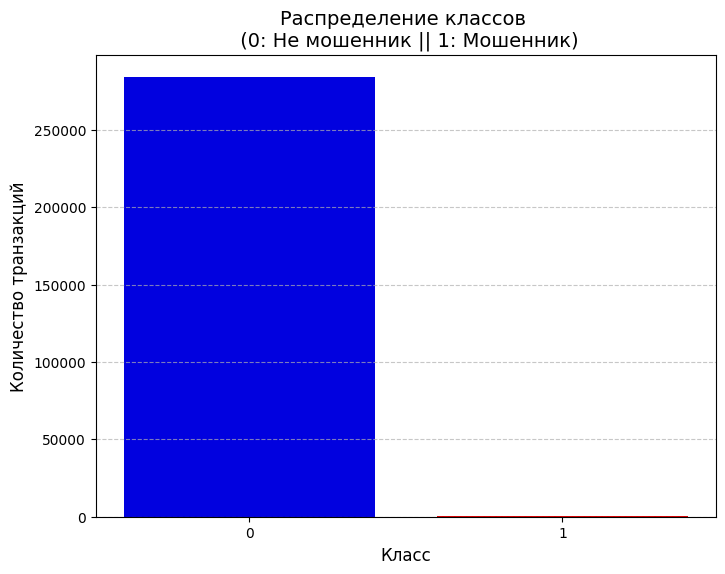

In [19]:
colors = ["#0101DF", "#DF0101"]

# Строим гистограмму целевой переменной
plt.figure(figsize=(8, 6))  # Устанавливаем размер графика
plt.title('Распределение классов \n (0: Не мошенник || 1: Мошенник)', fontsize=14)
plt.bar(df['Class'].value_counts().index, df['Class'].value_counts(), color=colors)
plt.xticks([0, 1])  # Переименовываем ось X
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Добавляем сетку по оси Y
plt.show()

Построим распределения по суммам и времени транзакций.

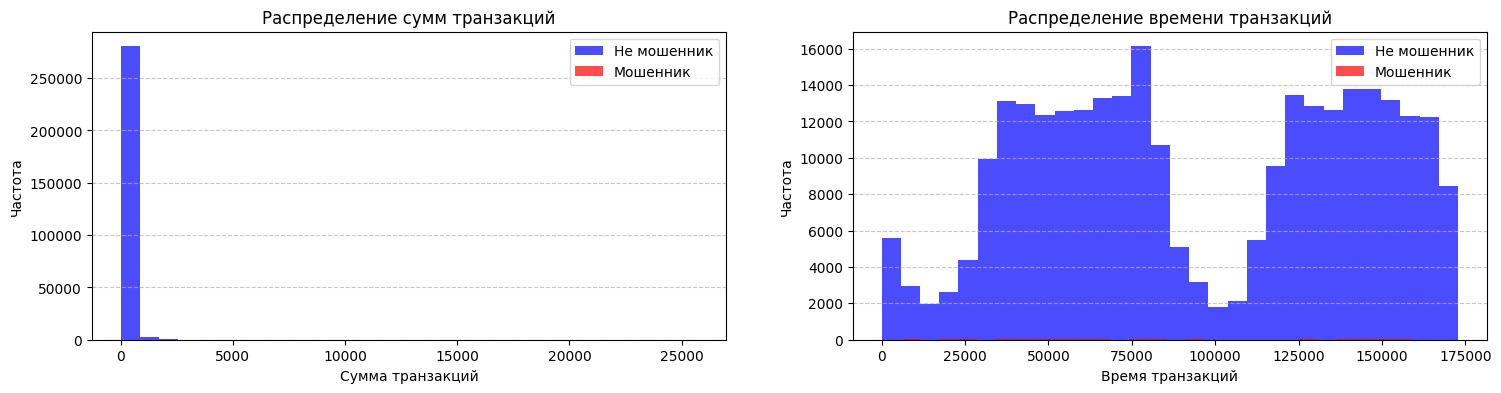

In [10]:
# Создать подграфики
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

# строим график распределения суммы транзакций
ax[0].hist(df['Amount'][df['Class'] == 0], bins=30, alpha=0.7, color='blue', label='Не мошенник')
ax[0].hist(df['Amount'][df['Class'] == 1], bins=30, alpha=0.7, color='red', label='Мошенник')
ax[0].set_title('Распределение сумм транзакций')
ax[0].set_xlabel('Сумма транзакций')
ax[0].set_ylabel('Частота')
ax[0].legend()
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# строим график распределения времени транзакций
ax[1].hist(df['Time'][df['Class'] == 0], bins=30, alpha=0.7, color='blue', label='Не мошенник')
ax[1].hist(df['Time'][df['Class'] == 1], bins=30, alpha=0.7, color='red', label='Мошенник')
ax[1].set_title('Распределение времени транзакций')
ax[1].set_xlabel('Время транзакций')
ax[1].set_ylabel('Частота')
ax[1].legend()
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Масштабирование
Первым делом нам необходимо отмасштабировать столбцы **Time** и **Amount**. Поскольку все остальные признаки уже отмасштабированы. Однако делать это нужно только строго **после** разбиения на обучающую выборку и тестовую.

Затем необходимо создать подвыборку из наших данных, чтобы иметь равное количество случаев мошенничества и не мошенничества, что поможет нашим моделям лучше понять закономерности, определяющие, является ли транзакция мошенничеством или нет.

## Зачем создавать подвыборку?
Наши данные имеют сильный дисбаланс. Использование исходного датасета приведет к следующим проблемам:
  - **Переобучение**: Наши модели классификации будут предполагать, что в большинстве случаев мошенничества не существует! Мы хотим, чтобы наша модель точно определяла, когда происходит мошенничество.
  - **Неверные корреляции:** Хотя мы не знаем, что обозначают признаки "V", будет полезно понять, как каждый из этих признаков влияет на результат (мошенничество или отсутствие мошенничества), поскольку, имея несбалансированный набор данных, мы не можем увидеть истинные корреляции между целевой переменной и признаками.

In [11]:
# Создаем экземпляр RobustScaler, который менее чувствителен к выбросам
rob_scaler = RobustScaler()

# Убираем целевую переменную 'Class' и сохраняем остальные данные в X, а целевую переменную - в y
X = df.drop('Class', axis=1)
y = df['Class']

# Разделяем данные на обучающую и тестовую выборки (80% на 20%)
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Проверяем типы данных в столбце 'Amount' обучающей выборки
rt_tmp = original_Xtrain['Amount']
print(f'Тип данных original_Xtrain["Amount"] {type(rt_tmp)}')  # Выводим тип данных Series
print(f'Тип данных original_Xtrain["Amount"].values {type(rt_tmp.values)}')  # Выводим тип данных массива NumPy
print(f'Данные original_Xtrain["Amount"].values {rt_tmp.values}')  # Выводим значения массива
print(f'Тип данных original_Xtrain["Amount"].values.reshape(-1,1) {type(rt_tmp.values.reshape(-1,1))}')  # Выводим тип данных после преобразования
print(f'Данные original_Xtrain["Amount"].values.reshape(-1,1) \n{rt_tmp.values.reshape(-1,1)} \n')  # Выводим преобразованные данные

# Преобразуем данные в 'scaled_amount' с помощью RobustScaler
original_Xtrain['scaled_amount'] = rob_scaler.fit_transform(original_Xtrain['Amount'].values.reshape(-1, 1))  # Применяем fit и transform на обучающей выборке
original_Xtest['scaled_amount'] = rob_scaler.transform(original_Xtest['Amount'].values.reshape(-1, 1))  # Применяем transform на тестовой выборке

# Масштабируем столбец 'Time' аналогично
original_Xtrain['scaled_time'] = rob_scaler.fit_transform(original_Xtrain['Time'].values.reshape(-1, 1))  # Применяем fit и transform на обучающей выборке
original_Xtest['scaled_time'] = rob_scaler.transform(original_Xtest['Time'].values.reshape(-1, 1))  # Применяем transform на тестовой выборке

# Убираем оригинальные столбцы 'Time' и 'Amount' из данных
original_Xtrain.drop(['Time', 'Amount'], axis=1, inplace=True)
original_Xtest.drop(['Time', 'Amount'], axis=1, inplace=True)

# Преобразуем DataFrame в массивы NumPy для дальнейшей обработки
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# Находим уникальные классы и их количество в обучающей выборке
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)

# Находим уникальные классы и их количество в тестовой выборке
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

# Выводим распределение классов
print('Распределение классов: \n')
print("Обучающий набор:", train_counts_label / len(original_ytrain))  # Выводим долю классов в обучающем наборе
print("Тестовый набор:", test_counts_label / len(original_ytest))  # Выводим долю классов в тестовом наборе

Тип данных original_Xtrain["Amount"] <class 'pandas.core.series.Series'>
Тип данных original_Xtrain["Amount"].values <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values [  9.99  45.9   11.99 ...   3.94   1.   113.  ]
Тип данных original_Xtrain["Amount"].values.reshape(-1,1) <class 'numpy.ndarray'>
Данные original_Xtrain["Amount"].values.reshape(-1,1) 
[[  9.99]
 [ 45.9 ]
 [ 11.99]
 ...
 [  3.94]
 [  1.  ]
 [113.  ]] 

Распределение классов: 

Обучающий набор: [0.99827075 0.00172925]
Тестовый набор: [0.99827955 0.00172045]


## Метод Random Under-Sampling

Применим метод *Random Under-Sampling*, который случайным образом удаляет объекты доминирующего класса и выравнивает соотношение классов.

#### Алгоритм:
<ul>
<li>Определяем степень несбалансированности (посчитали количество меток одного и другого класса выше)  </li>
<li>Как только мы определим, сколько случаев считаются мошенническими операциями (Fraud = "1"), мы должны довести количество немошеннических операций до того же количества, что и мошеннических (мы хотим получить соотношение 50/50 между классами), то есть это в подвыборке будет 492 случая мошенничества и 492 случая немошеннических операций.  </li>
<li> После применения этого метода мы получим подвыборку нашего набора данных с соотношением 50/50 в отношении наших классов. Наконец, не забудем <b>перемешать</b> наши данные для того, чтобы модели не зависили от порядка входных данных.</li>
</ul>

**Важно!**

Основная проблема данного метода заключается в том, что мы рискуем тем, что наши модели классификации не будут работать так точно, как нам хотелось бы, поскольку происходит большая потеря информации (выделение всего 492 немошеннических транзакций из 284 315 немошеннических транзакций).

In [12]:
# Перемешаем данные перед созданием подвыборок
df = df.sample(frac=1, random_state=42)  # Перемешиваем весь датафрейм

# Разделяем данные на фродовые и нефродовые транзакции
fraud_df = df.loc[df['Class'] == 1]  # Получаем все мошеннические операции
non_fraud_df = df.loc[df['Class'] == 0][:492]  # Берем 492 последних нефродовых транзакции

# Объединяем мошеннические и нефродовые операции для создания сбалансированной выборки
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])  # Конкатенируем датафреймы

# Перемешиваем строки датасета для случайности
new_df = normal_distributed_df.sample(frac=1, random_state=42)  # Используем random_state для воспроизводимости

# Выводим первые 5 строк новой выборки
new_df.head()  # Показываем первые 5 строк сбалансированного датафрейма

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
146884,87941.0,2.054361,-0.122642,-1.245717,0.189567,0.132497,-0.620765,0.059581,-0.148058,0.338940,...,-0.271204,-0.687048,0.271569,-0.497120,-0.270115,0.208619,-0.076075,-0.075428,0.99,0
95597,65385.0,-2.923827,1.524837,-3.018758,3.289291,-5.755542,2.218276,-0.509995,-3.569444,-1.016592,...,-0.511657,-0.122724,-4.288639,0.563797,-0.949451,-0.204532,1.510206,-0.324706,1354.25,1
96768,65927.0,0.955253,-0.833374,0.847147,0.725970,-1.322868,-0.238842,-0.565347,0.022443,-0.762247,...,-0.110554,-0.129397,-0.040892,0.364872,0.204756,-0.304578,0.055908,0.062489,156.00,0
75511,56098.0,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,-1.184468,...,1.208054,0.277612,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,170.92,1
255556,157284.0,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,-4.128505,...,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,0.77,1


In [13]:
df.to_csv("/content/drive/MyDrive/creditcard_full.csv")

In [14]:
new_df.shape

(984, 31)

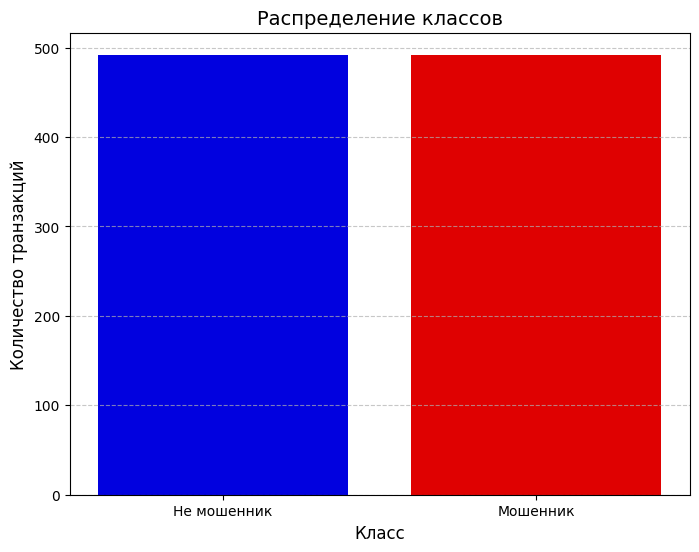

In [20]:
# Проверяем распределение целевой переменной
plt.figure(figsize=(8, 6))  # Устанавливаем размер графика
plt.title('Распределение классов', fontsize=14)
plt.bar(new_df['Class'].value_counts().index, new_df['Class'].value_counts(), color=colors)
plt.xticks([0, 1], ['Не мошенник', 'Мошенник'])  # Переименовываем ось X
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество транзакций', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Добавляем сетку по оси Y
plt.show()

## Матрица корреляций

Корреляционные матрицы очень важны для понимания данных. Мы хотим узнать, есть ли признаки, которые оказывают сильное влияние на то, является ли конкретная транзакция мошенничеством. Однако важно, чтобы мы использовали сбалансированную подвыборку, чтобы увидеть, какие признаки имеют высокую положительную или отрицательную корреляцию в отношении мошеннических операций.

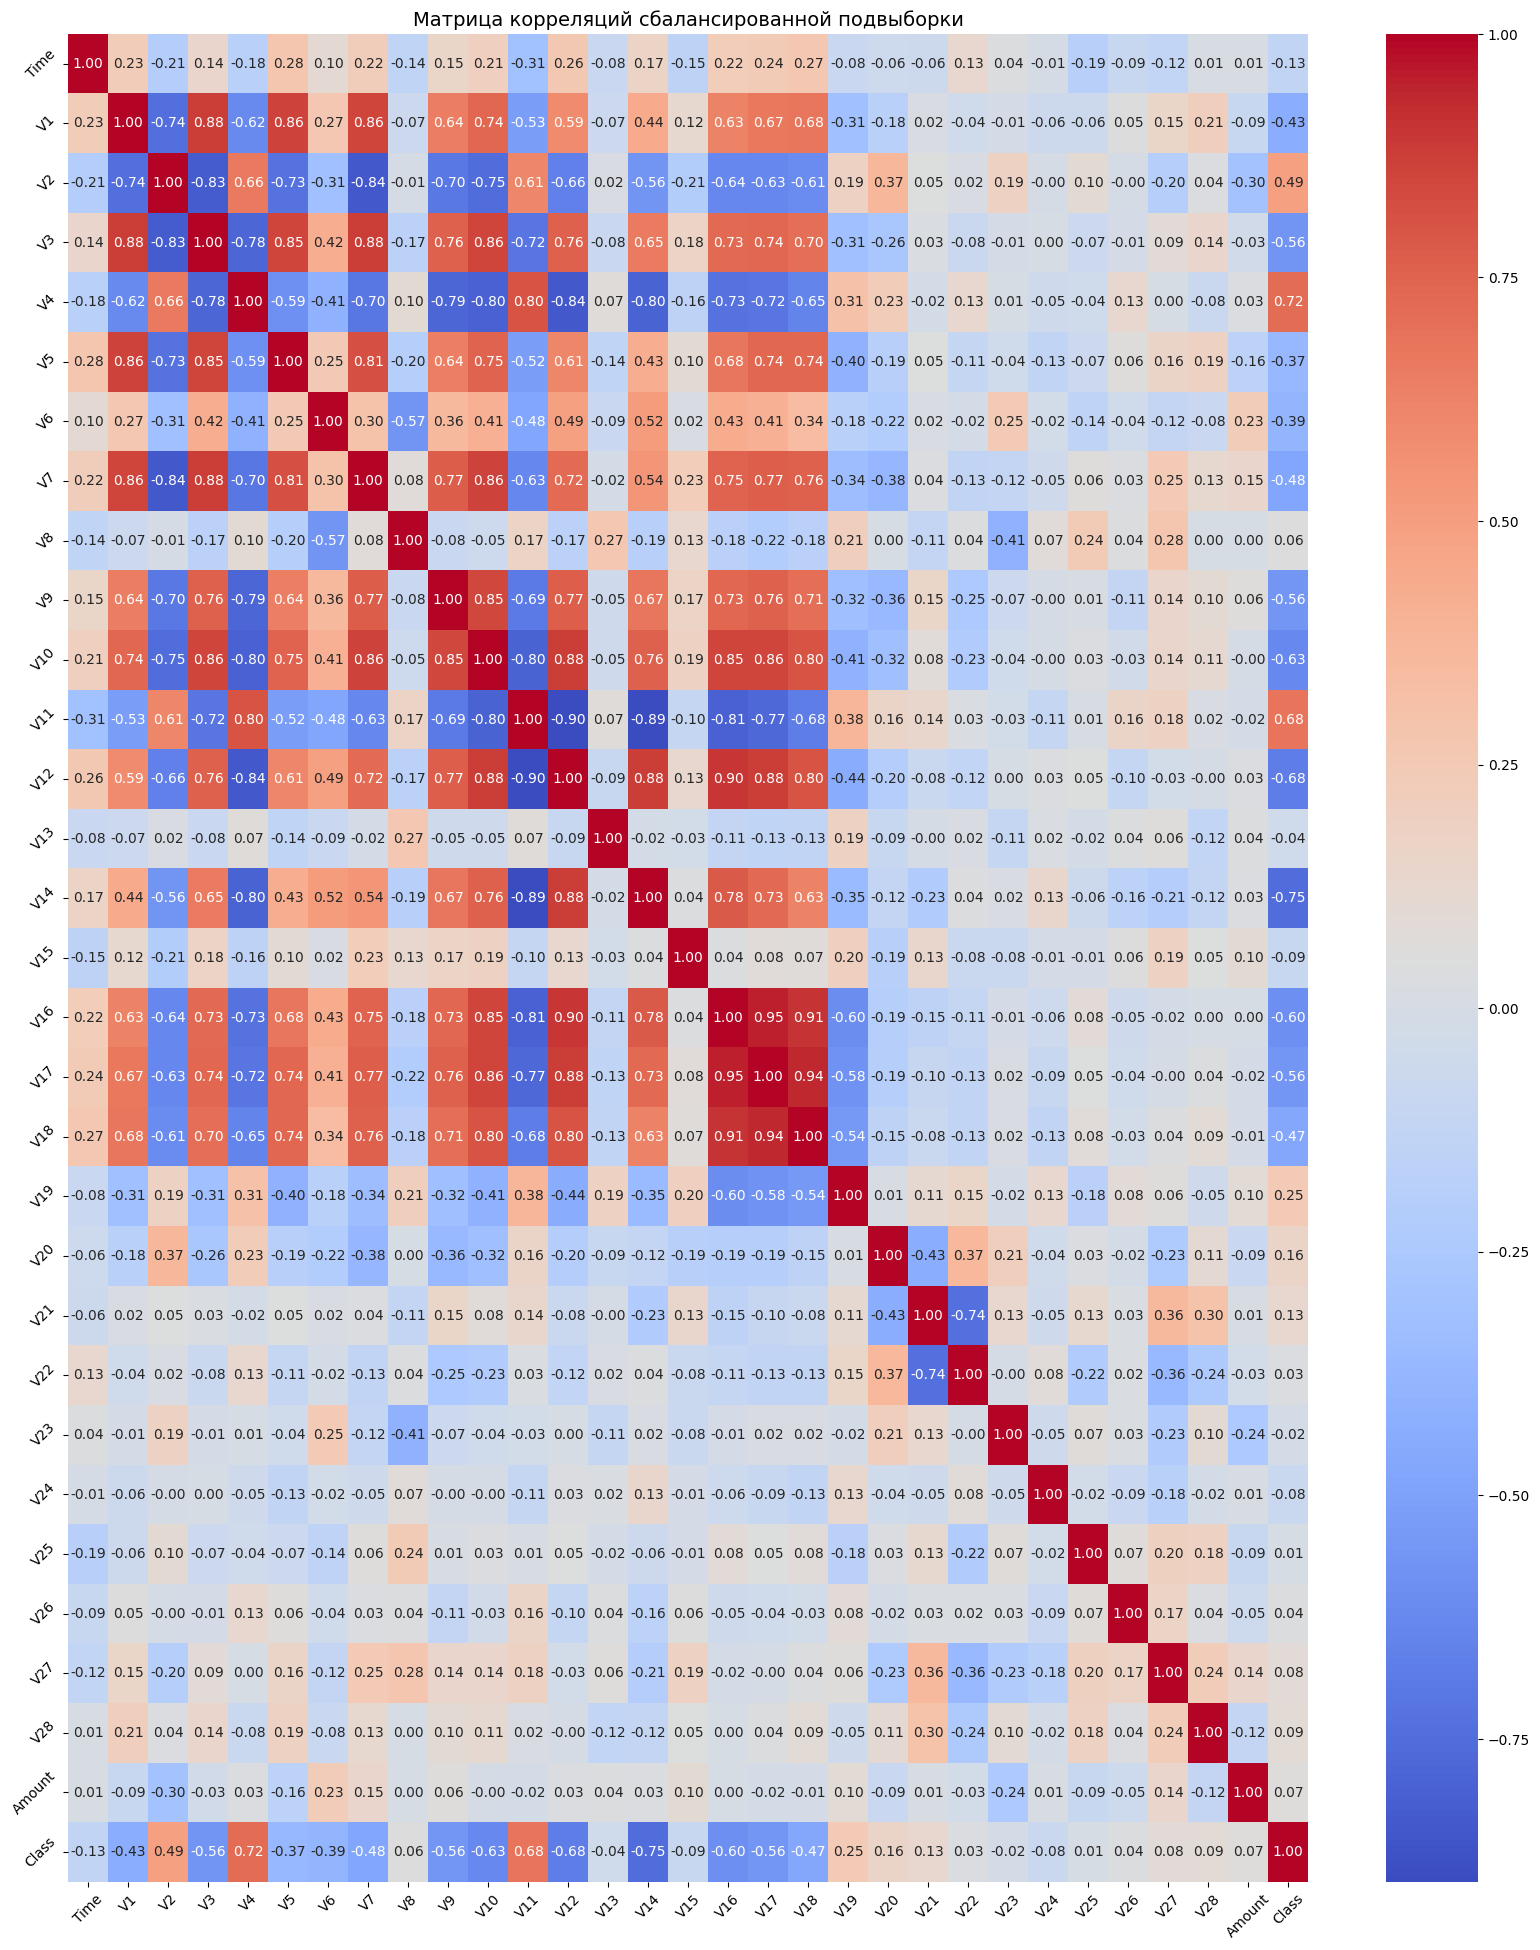

In [22]:
f, ax = plt.subplots(1, 1, figsize=(20, 24))

# Вычислим матрицу корреляций
correlation_matrix = new_df.corr()

# Построим тепловую карту корреляций
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)

ax.set_title('Матрица корреляций сбалансированной подвыборки', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

### Выводы:
<ul>
<li><b>Отрицательные корреляции: </b> Признаки Time, V1, V3, V5, V6, V7, V9, V10, V12, V13, V14, V15, V16, V17, V18, V23, V24 отрицательно коррелируют с целевой переменной Class. Другими словами, чем ниже значения, тем больше вероятность того, что конечным результатом будет мошенническая операция.  </li>
<li> <b> Положительные корреляции: </b> Признаки V2, V4, V8, V11, V19, V20, V21, V22, V25, V26, V27, V28, Amount положительно коррелируют с целевой переменной Class. То есть, чем выше значения, тем больше вероятность того, что конечным результатом будет мошенническая операция. </li>
</ul>

##Построение Boxplot

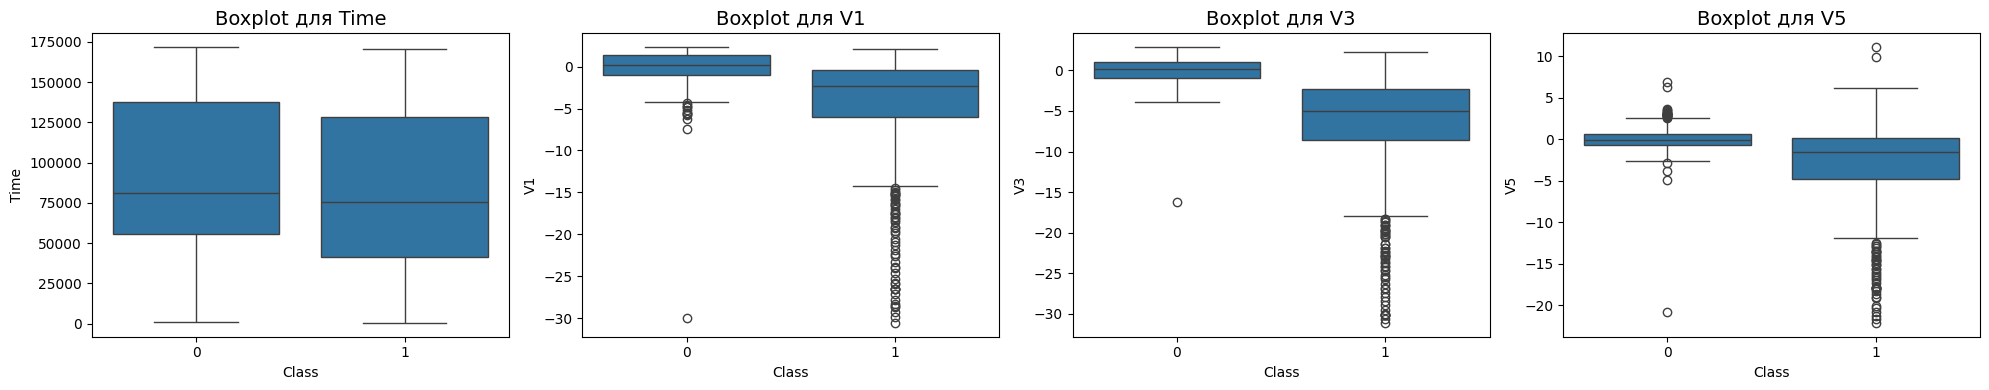

In [26]:
# Отрицательные корреляции с Class
negative_correlations = ['Time', 'V1', 'V3', 'V5']

f, axes = plt.subplots(ncols=4, figsize=(20, 4))

# Строим boxplot для каждой переменной с отрицательной корреляцией
for ax, col in zip(axes, negative_correlations):
    sns.boxplot(x='Class', y=col, data=new_df, ax=ax)
    ax.set_title(f'Boxplot для {col}', fontsize=14)

# Строим графики
plt.tight_layout()
plt.show()

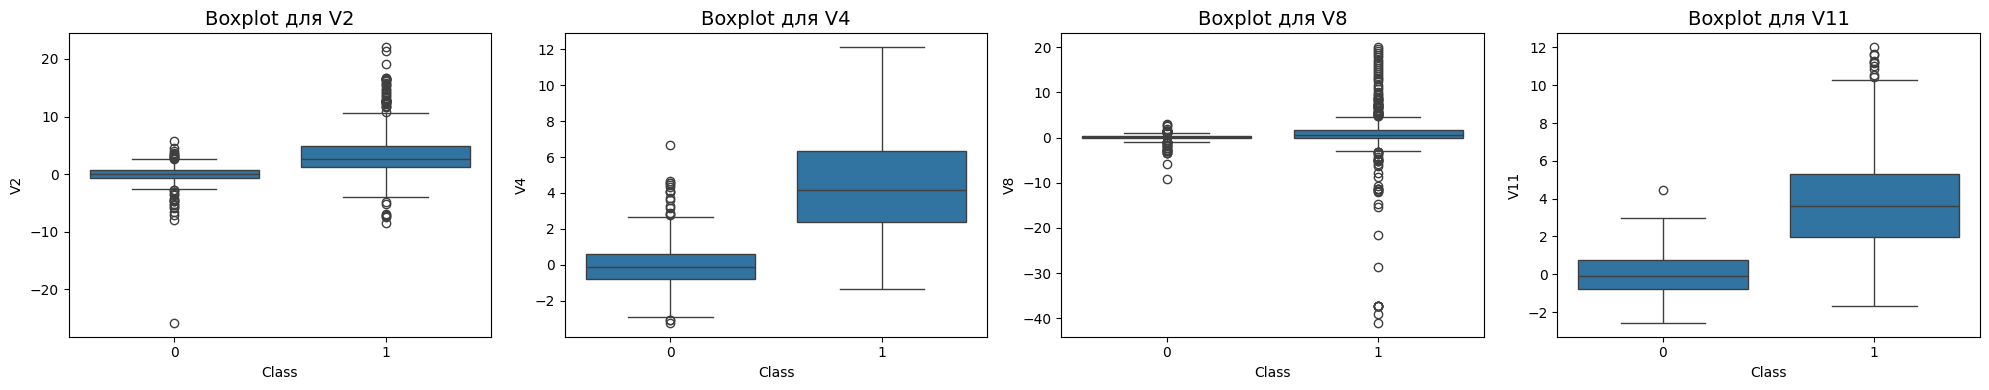

In [27]:
# Положительные корреляции с Class
negative_correlations = ['V2', 'V4', 'V8', 'V11']

f, axes = plt.subplots(ncols=4, figsize=(20, 4))

# Строим boxplot для каждой переменной с положительной корреляцией
for ax, col in zip(axes, negative_correlations):
    sns.boxplot(x='Class', y=col, data=new_df, ax=ax)
    ax.set_title(f'Boxplot для {col}', fontsize=14)

# Строим графики
plt.tight_layout()
plt.show()

## Выводы:
В мошеннических транзакциях наблюдаются выбросы, которые могут негативно влиять на процесс кластеризации и обучение модели. Наличие выбросов может привести к неверным выводам модели, что снизит ее эффективность. Выбросы могут создавать асимметричные распределения. Неправильная интерпретация выбросов может привести к неверной классификации транзакций, увеличивая риск мошеннических действий.

## Обработка выбросов

Наша основная цель в этом разделе - удалить выбросы из признаков, которые имеют высокую корреляцию с целевой переменной. Это положительно скажется на точности наших моделей.


### Метод межквартильного размаха:
<ul>
<li> <b>Interquartile Range (IQR): </b> Рассчитываем разницу между 75-м процентилем и 25-м процентилем. Наша цель - создать порог за пределами 75-го и 25-го процентилей, чтобы в случае, если какой-то экземпляр выборки преодолеет этот порог, он был удален.  </li>
<li> <b>Построить Boxplots: </b> С помощью boxplot легко увидеть 25-й и 75-й процентили и выбросы. </li>
</ul>

Надо быть внимательным к тому, как далеко мы хотим установить порог для удаления выбросов. Мы определяем порог путем умножения числа (например, 1.5) на интерквартильный размах. Чем выше этот порог, тем меньше выбросов будет обнаружено, а чем ниже этот порог, тем больше выбросов будет обнаружено.  <br><br>

Мы хотим больше сосредоточиться именно на сильных выбросах, а не просто на выбросах. Почему? Потому что удалив все выбросы, мы можем столкнуться с риском потери информации, что приведет к снижению точности наших моделей.


### Итого:
<ul>
<li> <b> Строим распределения </b>  </li>
<li><b>Определяем порог </b> </li>
<li> <b>Удаляем выбросы </b> </li>
<li> <b> Строим Boxplot </b> </li>
</ul>

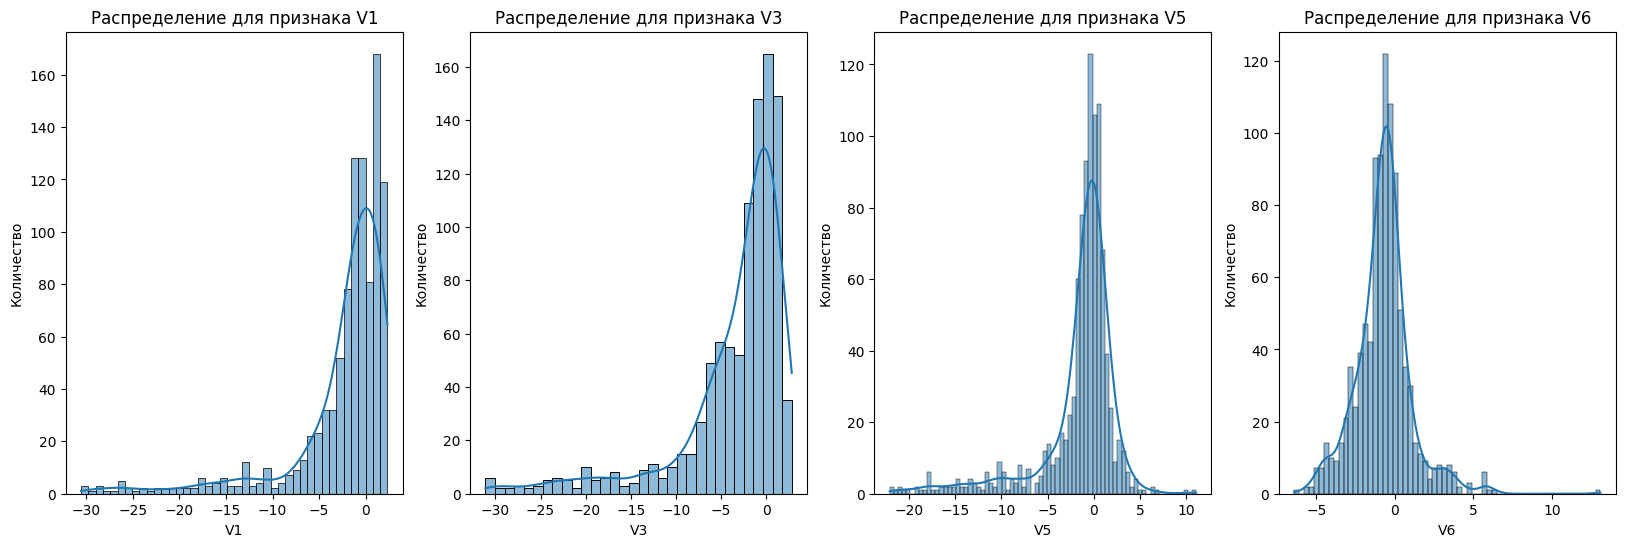

In [33]:
# Строим распределения для признаков с отрицательной корреляцией
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6))

# Признаки, отрицательно коррелирующие с целевой переменной Class
sns.histplot(new_df['V1'], ax=ax1, kde=True)
ax1.set_title('Распределение для признака V1')
ax1.set_ylabel('Количество')
sns.histplot(new_df['V3'], ax=ax2, kde=True)
ax2.set_title('Распределение для признака V3')
ax2.set_ylabel('Количество')
sns.histplot(new_df['V5'], ax=ax3, kde=True)
ax3.set_title('Распределение для признака V5')
ax3.set_ylabel('Количество')
sns.histplot(new_df['V6'], ax=ax4, kde=True)
ax4.set_title('Распределение для признака V6')
ax4.set_ylabel('Количество')

plt.show()

In [48]:
# Функция для удаления выбросов
def remove_outliers(df, feature):
    data = df[feature].loc[df['Class'] == 1].values
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25
    # Определяем порог
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # Добавление условия для проверки класса
    outliers = [x for x in data if x < lower or x > upper]
    print('Количество выбросов в {}: {}'.format(feature, len(outliers)))

    return df.drop(df[(df['Class'] == 1) & ((df[feature] > upper) | (df[feature] < lower))].index)

new_df_without_outliers = new_df
# Извлекаем корреляции с Class
class_corr = correlation_matrix['Class']
# Берём признаки с умеренной и сильной корреляцией
features_list= list(class_corr[(class_corr > 0.3) | (class_corr < -0.3)].index)
for feature in features_list:
    # Вызов функции для признаков
    new_df_without_outliers = remove_outliers(new_df_without_outliers, feature)
new_df_without_outliers

Количество выбросов в V1: 52
Количество выбросов в V2: 26
Количество выбросов в V3: 20
Количество выбросов в V4: 0
Количество выбросов в V5: 25
Количество выбросов в V6: 4
Количество выбросов в V7: 11
Количество выбросов в V9: 3
Количество выбросов в V10: 5
Количество выбросов в V11: 0
Количество выбросов в V12: 0
Количество выбросов в V14: 0
Количество выбросов в V16: 0
Количество выбросов в V17: 0
Количество выбросов в V18: 0
Количество выбросов в Class: 0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
146884,87941.0,2.054361,-0.122642,-1.245717,0.189567,0.132497,-0.620765,0.059581,-0.148058,0.338940,...,-0.271204,-0.687048,0.271569,-0.497120,-0.270115,0.208619,-0.076075,-0.075428,0.99,0
96768,65927.0,0.955253,-0.833374,0.847147,0.725970,-1.322868,-0.238842,-0.565347,0.022443,-0.762247,...,-0.110554,-0.129397,-0.040892,0.364872,0.204756,-0.304578,0.055908,0.062489,156.00,0
75511,56098.0,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,-1.184468,...,1.208054,0.277612,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,170.92,1
255556,157284.0,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,-4.128505,...,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,0.77,1
208257,137041.0,-0.719251,-0.918495,2.175468,-2.667620,-1.094123,0.355401,-0.581350,0.189298,-1.867227,...,-0.069422,-0.021690,-0.003213,0.568798,0.320581,-0.159864,0.050443,0.086122,101.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239499,150138.0,-2.150855,2.187917,-3.430516,0.119476,-0.173210,0.290700,-2.808988,-2.679351,-0.556685,...,-0.073205,0.561496,-0.075034,-0.437619,0.353841,-0.521339,0.144465,0.026588,50.00,1
43624,41582.0,-1.048005,1.300219,-0.180401,2.589843,-1.164794,0.031823,-2.175778,0.699072,-1.140208,...,0.549014,0.624321,-0.136663,0.131738,0.030921,-0.176701,0.504898,0.069882,39.45,1
103626,68738.0,-3.599934,4.022775,-2.735797,0.416448,-0.546681,1.114840,-3.332706,-3.035458,-2.103863,...,-2.353510,0.747557,0.369075,-1.460187,-0.041429,0.497594,-0.623617,0.009661,0.76,0
119714,75556.0,-0.734303,0.435519,-0.530866,-0.471120,0.643214,0.713832,-1.234572,-2.551412,-2.057724,...,-1.004877,1.150354,-0.152555,-1.386745,0.004716,0.219146,-0.058257,0.158048,29.95,1


Видим, что выбросы удалились из датасета

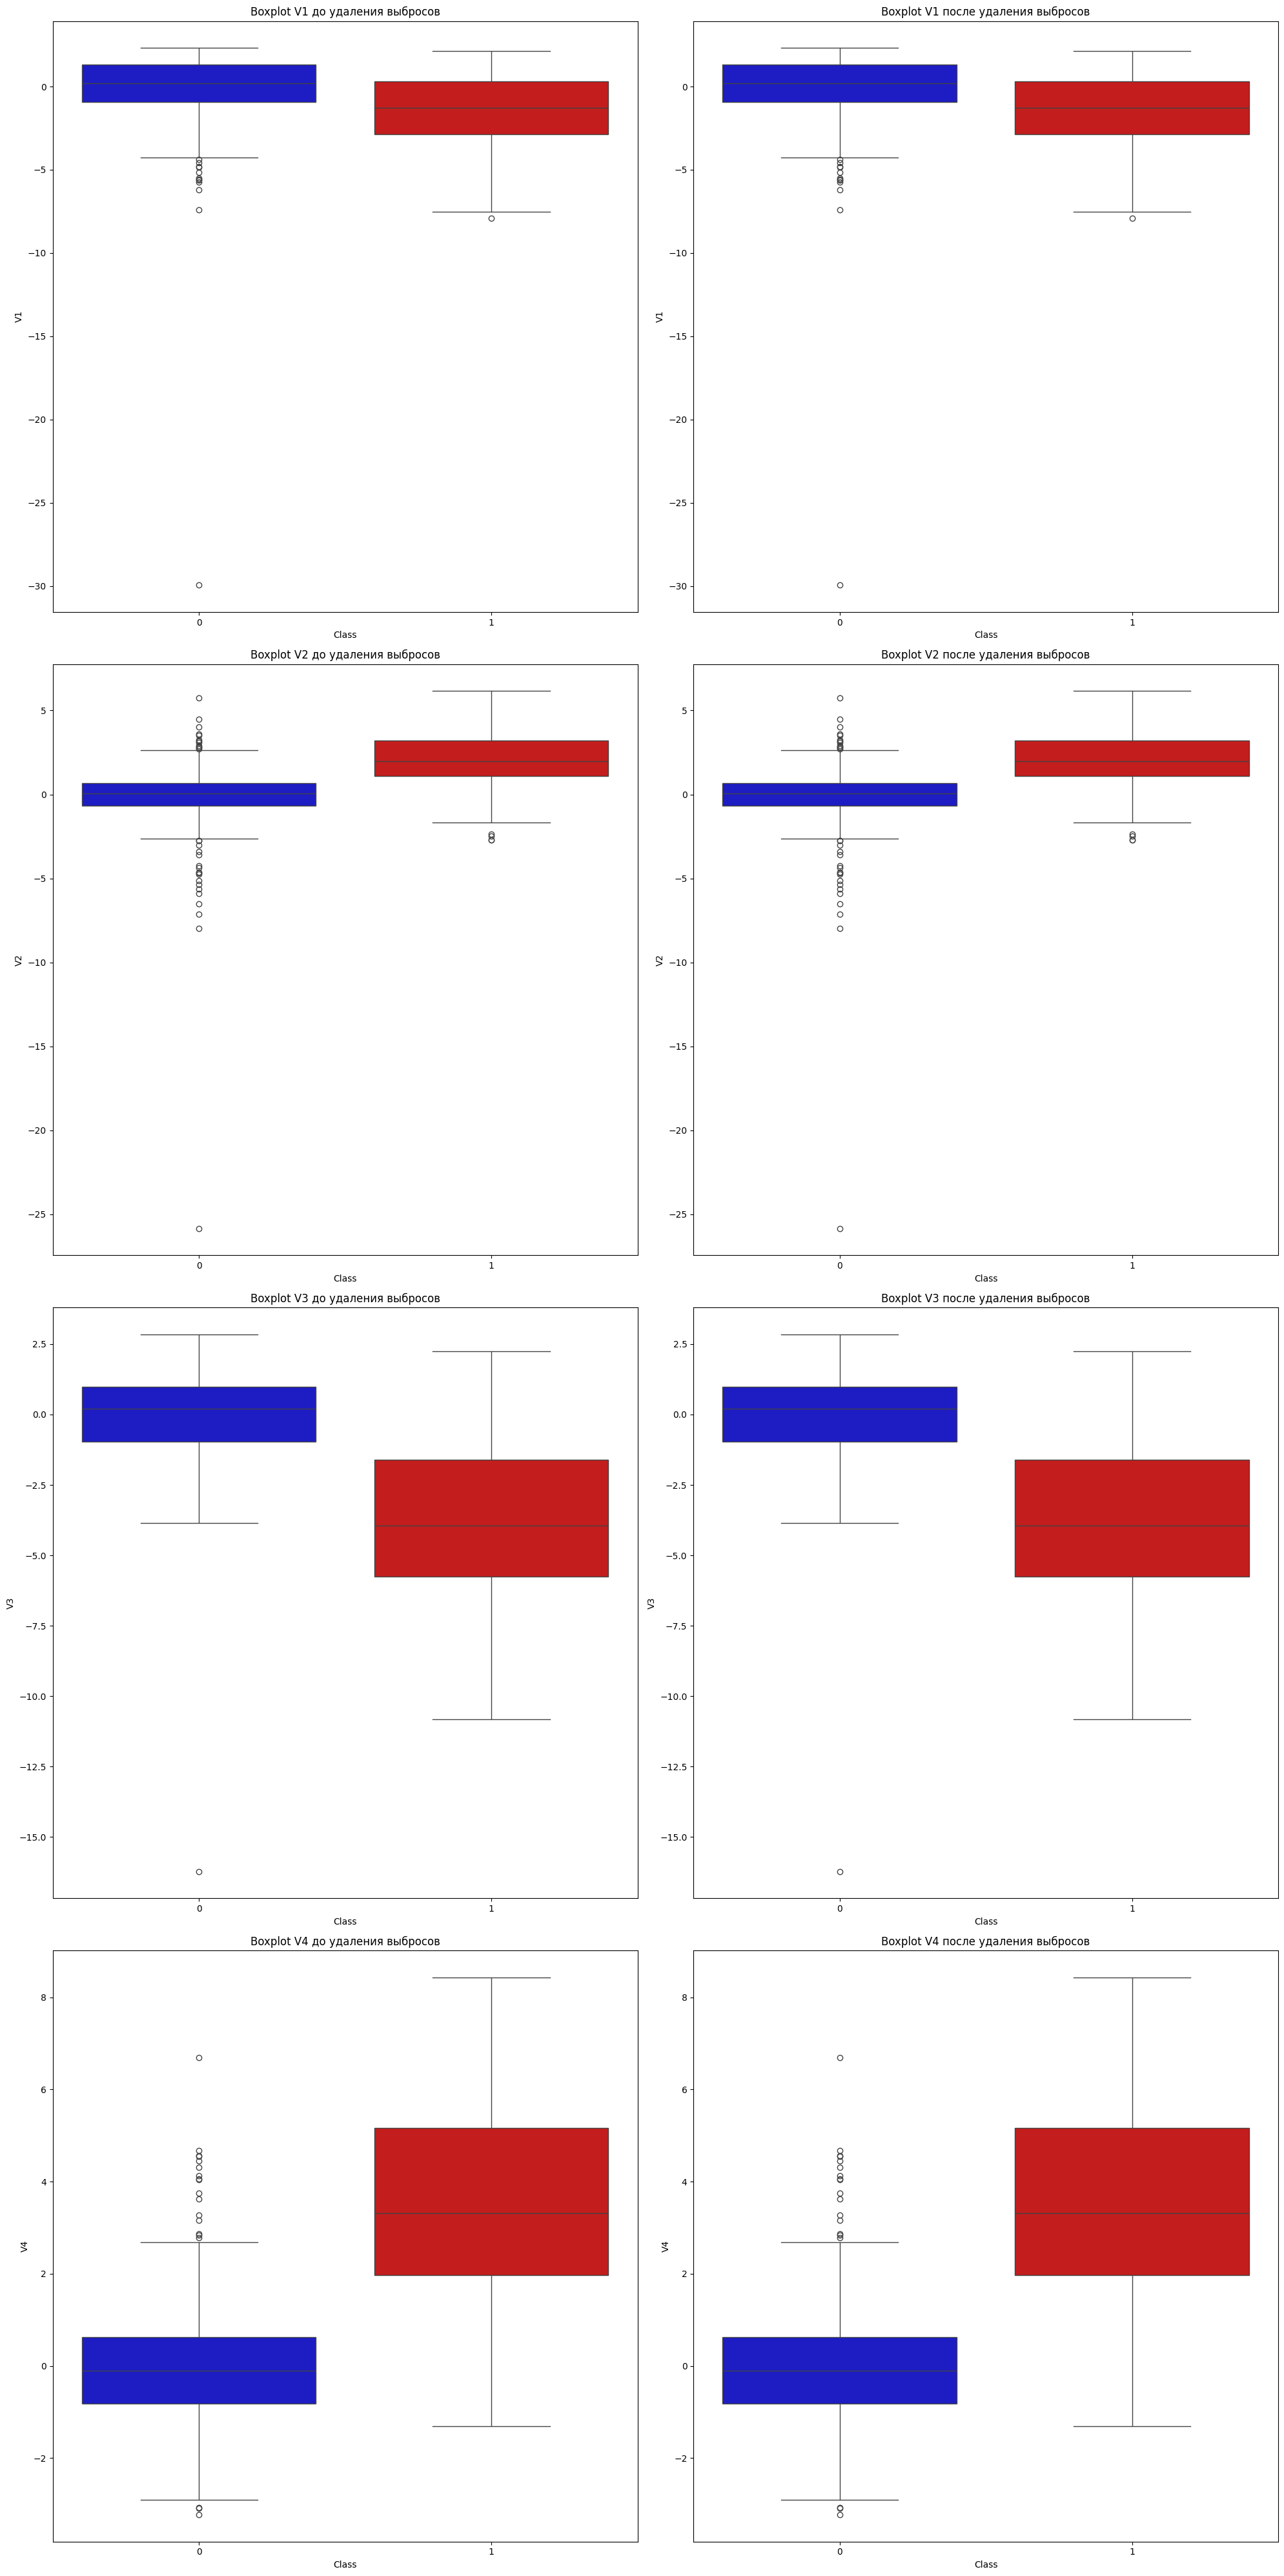

In [57]:
# Визуализируем Boxplots для первых 4 признаков до удаления и после
f, ax = plt.subplots(4, 2, figsize=(20, 40))

# Boxplots для первых 4 признаков
for i, feature in enumerate(features_list):
    if i < 4:
      sns.boxplot(x=new_df['Class'], y=new_df[feature], ax=ax[i, 0], palette=colors)
      ax[i, 0].set_title(f'Boxplot {feature} до удаления выбросов')

      sns.boxplot(x=new_df_without_outliers['Class'], y=new_df_without_outliers[feature], ax=ax[i, 1], palette=colors)
      ax[i, 1].set_title(f'Boxplot {feature} после удаления выбросов')

plt.tight_layout()
plt.show()

In [50]:
# Теперь у нас в датафрейме new_df будут лежать данные без выбросов
new_df = new_df_without_outliers

### Понижение размерности и кластеризация

Для того, чтобы убедиться, что наши классы являются разделимыми (иначе строить модели нет смысла), выполним кластеризацию с помощью трех различных техник кластеризации.


In [52]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

X.drop(['Time','Amount'], axis=1, inplace=True) # Tак как Time и Amount не коррелируют почти с таргетом

# T-SNE алгоритм
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=12).fit_transform(X)
t1 = time.time()
print("T-SNE заняло {:.2f} сек".format(t1 - t0))

# PCA алгоритм
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=12).fit_transform(X)
t1 = time.time()
print("PCA заняло {:.2f} сек".format(t1 - t0))

# TruncatedSVD алгоритм
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, random_state=12).fit_transform(X)
t1 = time.time()
print("Truncated SVD заняло {:.2f} сек".format(t1 - t0))

T-SNE заняло 7.71 сек
PCA заняло 0.01 сек
Truncated SVD заняло 0.04 сек


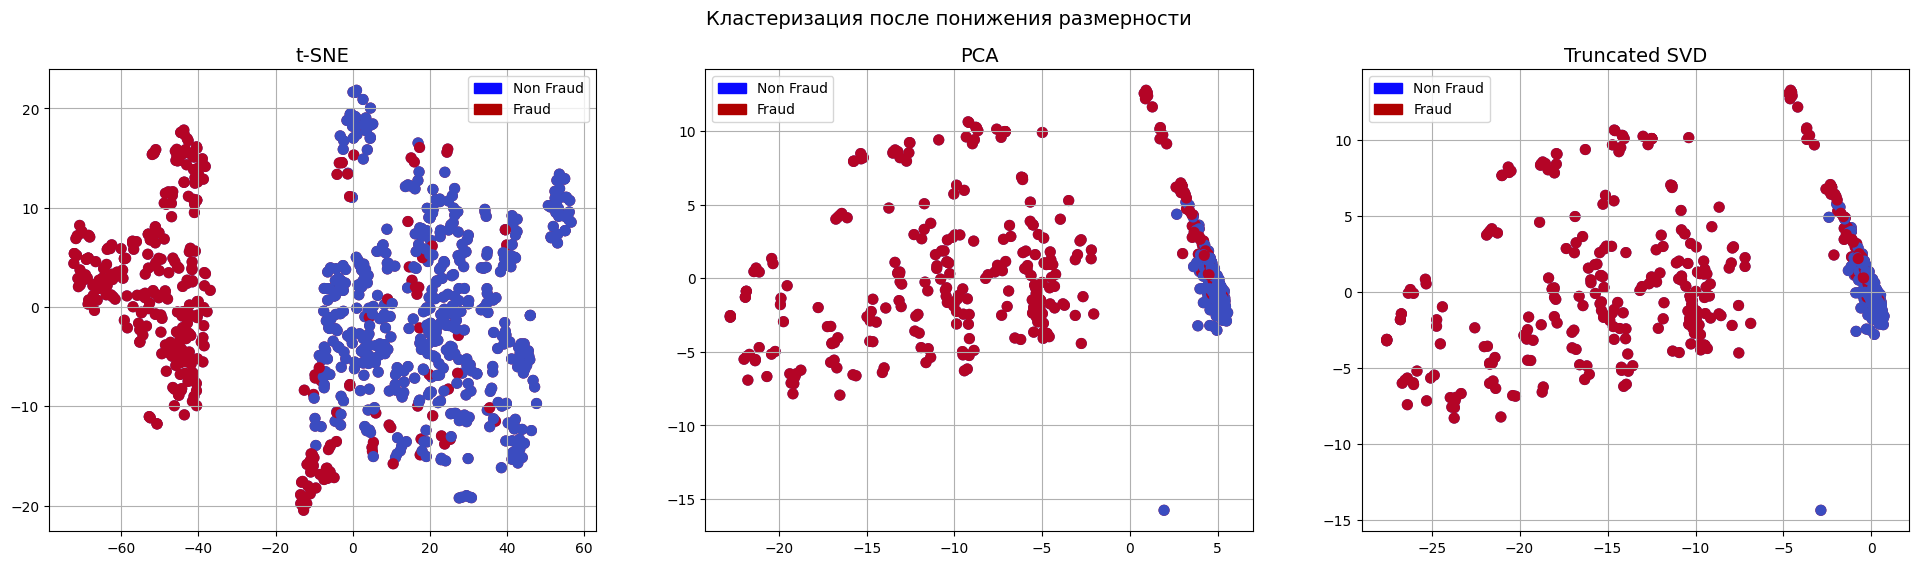

In [53]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Кластеризация после понижения размерности', fontsize=14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='Non Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:, 0], X_reduced_pca[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 0), cmap='coolwarm', label='Non Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:, 0], X_reduced_svd[:, 1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<h3> Выводы: </h3>
<ul>
<li>Алгоритм t-SNE может довольно точно кластеризовать случаи мошенничества и не мошенничества в нашем наборе данных. </li>
<li> Классы целевой переменной однозначно разделимы, а значит мы можем строить модели! </li>
</ul>

In [54]:
new_df.to_csv('/content/drive/MyDrive/creditcard_short.csv')